# Exploratory Data Analysis for the Classification Problem

This notebook aims to perform the exploratory data analysis regarding the failure classification problem.

In [1]:
# imports
import os
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind

# ignore warnings (to keep notebook clean)
warnings.filterwarnings('ignore')

# definition of constants
DATASOURCE = '../../data/2_processed/'
DATANAME = 'class_data.csv'
DATASINK = '../../data/3_model_data/'

In [2]:
# load data
data = pd.read_csv(os.path.join(DATASOURCE, DATANAME))
data.head()

runtime    set1    set2   set3    tag1    tag2     tag3     tag4   tag5  \
0        1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1        2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2        3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3        4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4        5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

    tag6  ...    tag13    tag14   tag15  tag16  tag17  tag18  tag19  tag20  \
0  21.61  ...  2388.02  8138.62  8.4195   0.03    392   2388  100.0  39.06   
1  21.61  ...  2388.07  8131.49  8.4318   0.03    392   2388  100.0  39.00   
2  21.61  ...  2388.03  8133.23  8.4178   0.03    390   2388  100.0  38.95   
3  21.61  ...  2388.08  8133.83  8.3682   0.03    392   2388  100.0  38.88   
4  21.61  ...  2388.04  8133.80  8.4294   0.03    393   2388  100.0  38.90   

     tag21  failure  
0  23.4190        0  
1  23.4236        0  
2  23.3442        0  
3  23.3739        0  
4  23.4044        0  

[5 rows x 26 columns]

Since a part of exploratory data analysis was already performed regarding data quality issues, it will not be repeated in this step. We will simply apply the same treatments applied there. The only exception will be removal of columns due to low correlation, because the approach will be different for the classification problem.

In [3]:
# drop zero or very low variance - the same dropped for the regression problem
data.drop(['set3', 'tag1', 'tag5', 'tag6', 'tag10', 'tag16', 'tag18', 'tag19'], axis=1, inplace=True)
data.head()

runtime    set1    set2    tag2     tag3     tag4    tag7     tag8  \
0        1 -0.0007 -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1        2  0.0019 -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2        3 -0.0043  0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3        4  0.0007  0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4        5 -0.0019 -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

      tag9  tag11   tag12    tag13    tag14   tag15  tag17  tag20    tag21  \
0  9046.19  47.47  521.66  2388.02  8138.62  8.4195    392  39.06  23.4190   
1  9044.07  47.49  522.28  2388.07  8131.49  8.4318    392  39.00  23.4236   
2  9052.94  47.27  522.42  2388.03  8133.23  8.4178    390  38.95  23.3442   
3  9049.48  47.13  522.86  2388.08  8133.83  8.3682    392  38.88  23.3739   
4  9055.15  47.28  522.19  2388.04  8133.80  8.4294    393  38.90  23.4044   

   failure  
0        0  
1        0  
2        0  
3        0  
4        0

## Class Balance Analysis

In this step, we will check the balance of the classes on the dataset.

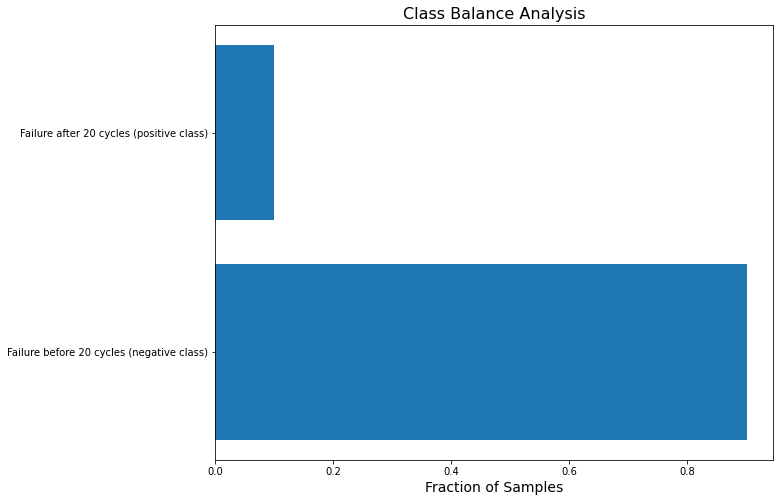

In [4]:
# count the examples of each class
class_count = data.failure.value_counts(normalize=True)

# make a barplot with class count
plt.figure(figsize=(10,8))
plt.barh(y=class_count.index, width=class_count.values)
plt.xlabel('Fraction of Samples', size=14)
plt.title('Class Balance Analysis', size=16)
plt.yticks(ticks=[0,1], labels=['Failure before 20 cycles (negative class)', 
                                'Failure after 20 cycles (positive class)'])
plt.show()

One can check that check that the class are very imbalaced. This situation leads to the necessity of application of a resampling procedure. Training models in imbalanced datasets lead to bias towards the most frequent class. In this case, the model will have the bias to predict all the failures to happen before the 20 cyles, which will prejudice the model's recall score, because it will result in several false negatives. In business context, this cause the increase of cost associated with early maintenances.

Resampling algorithms can be of three kinds:

- *Oversampling*: where the minority class have synthetic data created until the balance is achieved. A classical algorithm is SMOTE (Synthetic Minority Oversampling Technique)
- *Undersampling*: where the majority class have data eliminated until the balance is achieved. An example is RandomUnderSamplig.
- Hybrid approaches: join together over and under sampling techniques

Here, in this work, we'll apply the SMOTE technique, because we do not want to lose data points by eliminating the majority class.

## Check the overall type of class separability

In this step, we will check how the classes of failures are separated regarding each predictor.

<Figure size 1296x1296 with 0 Axes>

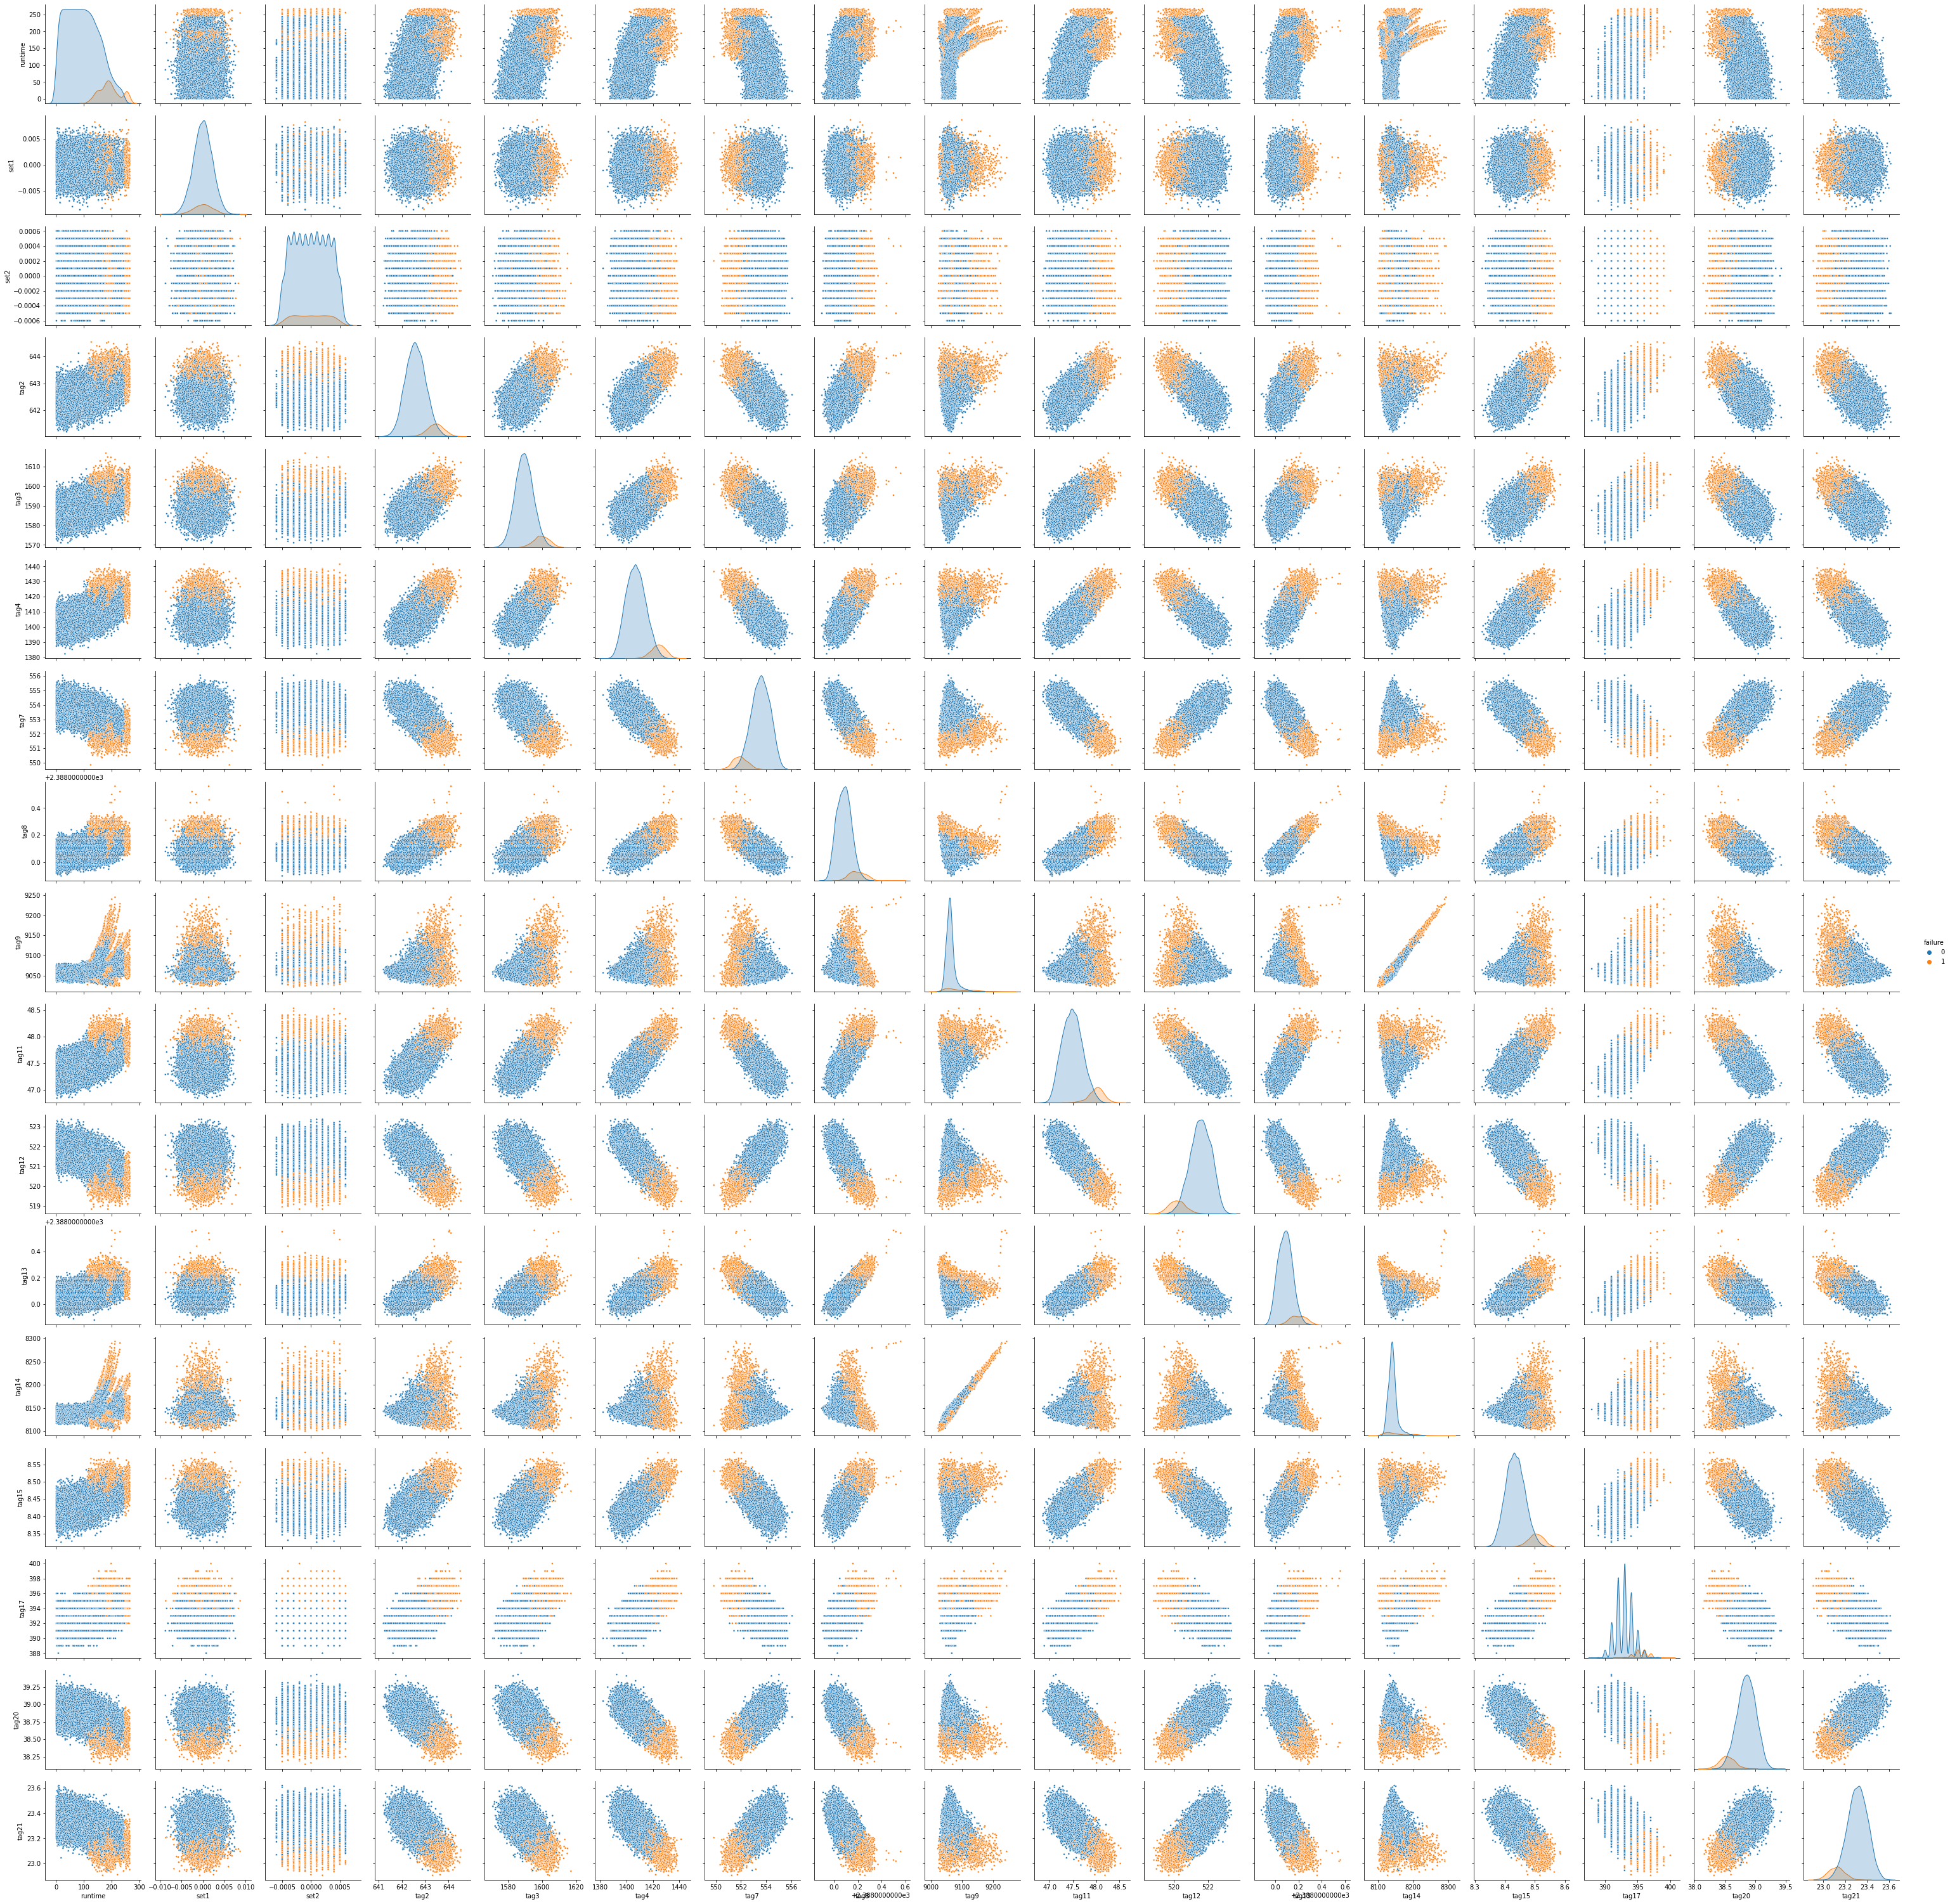

In [5]:
# create scatter plots colored by class
plt.figure(figsize=(18,18))
sns.pairplot(data, hue='failure', markers='.', palette='tab10')
plt.show()

The colored pairplots show that the classes are approximately well separated, which is an opportunity to test the application of linear algorithms - such as `LogisticRegression` and `Support Vector Machines`. In addition, the tree based ensemble algorithms will also be tested, due to the observed cross-correlation between features, similarly as done for regression problem.

## Feature Selection based on Hypothesis Tests

Calculating correlations is not the best approach for evaluating candidates for classification problems, since the concept of variance (and thus, of correlation) is not applicable for classes. Hence, a possible way to investigate if a feature is a good separator for the classes is to apply a hypthesis test. By splitting the dataset in two classes and testing for the difference of averages - it applies only to class against continuous features - it is possible to determine the candidates to split the classes.

In this study, we'll test each feature independently, which means that this feature selection will not consider the effect of other variables in the results. Like it was proposed in the regression problem, a better feature selection algorithm will be applied further in the modeling step. The applied test will be the following:

- **Mann-Whithney U Test**: a non-parametric test for two samples, based on the comparison os samples' ranks. It does not make assumptions about groups distributions
- **Student's t Test for Independent samples**: a parametric and more statistically powerfull test, that assumes that the data has normal distribution. Here, we are assumed as valid the Central Limit Theorem, due to the large sample size. We will test both for heterocedastic as for homocedastic cases.

For Mann-Whithney's, the hypotheses tested are:

- $H_0$: the two groups have similar rank ordering and thus, the sample distributions are equal
- $H_1$: there is a clustering of values in respect to ranking in each sample and thus, they are different

For Student's test, the hypotheses are:

- $H_0$: the average of both samples are statistically equal
- $H_1$: the average of both are statistically different

In both cases, it will be assumed a significance value of $\alpha = 0.05$ in the two-tailed approach.

In [6]:
# calculate the tests p-values 
mwu = []
ttest_het = []
ttest_homo = []
for col in data.columns:

    # not test failure class against itself
    if col not in ['failure']:

        # extract each group
        group0 = data.loc[data.failure==0, col].values
        group1 = data.loc[data.failure==1, col].values

        # calculate mann whithney's u p-value
        _, p = mannwhitneyu(group0, group1)
        mwu.append(p)

        # Student's heterocedastic case
        _, p = ttest_ind(group0, group1, equal_var=False)
        ttest_het.append(p)

        # Student's homocedastic case
        _, p = ttest_ind(group0, group1, equal_var=True)
        ttest_homo.append(p)

# create summary dataframe
summary_data = pd.DataFrame(list([col for col in data.columns if col != 'failure']), columns=['tag'])
summary_data['mwu'] = mwu
summary_data['student_hetero'] = ttest_het
summary_data['student_homo'] = ttest_homo

In [7]:
# show results
summary_data.set_index('tag', drop=True)

mwu  student_hetero  student_homo
tag                                                 
runtime   0.000000e+00    0.000000e+00      0.000000
set1      4.596504e-02    3.135268e-02      0.026381
set2      7.583182e-01    7.490502e-01      0.752044
tag2      0.000000e+00    0.000000e+00      0.000000
tag3      0.000000e+00    0.000000e+00      0.000000
tag4      0.000000e+00    0.000000e+00      0.000000
tag7      0.000000e+00    0.000000e+00      0.000000
tag8      0.000000e+00    0.000000e+00      0.000000
tag9     4.531002e-114   1.244844e-141      0.000000
tag11     0.000000e+00    0.000000e+00      0.000000
tag12     0.000000e+00    0.000000e+00      0.000000
tag13     0.000000e+00    0.000000e+00      0.000000
tag14     5.982710e-39    1.568558e-92      0.000000
tag15     0.000000e+00    0.000000e+00      0.000000
tag17     0.000000e+00    0.000000e+00      0.000000
tag20     0.000000e+00    0.000000e+00      0.000000
tag21     0.000000e+00    0.000000e+00      0.000000

Very similarly to what was observed in the regression problem exploratory analysis, the variables `set1` and `set2` showed little significance in the differences presented, since their *p-values* were higher or close to the significance level adopted. The *p-value* is the probability of being wrong by refusing the null ($H_0$) hypothesis. Since all *p-values* obtained, for the three tests were concordant and smaller than the significance level, than all the variables will be kept in the classification dataset, except for `set1` and `set2`.

Although the `set1` showed *p-values* lower than the significance level, there little evidence on the pairplot histograms, that it will help to separate the classes. Hence, it will be also removed.

It's important to remeber that those effects of hypothesis testing can be masked by spurious correlations effects and thus, they may not represent a real effect on the prediction of classes.

In [8]:
# drop the weak correlated features
data.drop(['set1', 'set2'], axis=1, inplace=True)
data.head()

runtime    tag2     tag3     tag4    tag7     tag8     tag9  tag11   tag12  \
0        1  641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47  521.66   
1        2  642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49  522.28   
2        3  642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27  522.42   
3        4  642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13  522.86   
4        5  642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28  522.19   

     tag13    tag14   tag15  tag17  tag20    tag21  failure  
0  2388.02  8138.62  8.4195    392  39.06  23.4190        0  
1  2388.07  8131.49  8.4318    392  39.00  23.4236        0  
2  2388.03  8133.23  8.4178    390  38.95  23.3442        0  
3  2388.08  8133.83  8.3682    392  38.88  23.3739        0  
4  2388.04  8133.80  8.4294    393  38.90  23.4044        0

In [9]:
# save the treated dataset
data.to_csv(os.path.join(DATASINK, 'class_model_data.csv'), index=False)